### Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación

### Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones 2021
Búsqueda y Recomendación para Textos Legales

Mentor: Jorge E. Pérez Villella

# Práctico Análisis y Visualización

Integrantes:

### Objetivos:

Normalizar el corpus generado en el práctico anterior, teniendo en cuenta los siguientes aspectos:

* tokenización, 
* pasar a minúsculas, 
* separar puntuación, 
* stemming y lematización, 
* eliminar stopwords (o no), 
* eliminar las palabras con frecuencia menor a n. 

Analizar las palabras más frecuentes de todo el corpus, por fuero y de 5 documentos. Compararlo con el resultado obtenido en el ejercicio anterior. Se observa algún cambio significativo?

Hacer una explicación con ejemplos tomando algunas palabras al azar entre lo que es stemming y lemmatizing para entender que nos da cada uno de estos procesos y cual es conveniente utilizar en cada caso.

Opcional:

* Investigar que es Segmentación y compararlo con Tokenización. Ejemplificar con un documento.
* Investigar NER (Named Entity Recognition - Reconocimiento de Entitades Nombradas). Buscar las Entidadas Nombradas mas frecuentes en todo el corpus y por fuero. 


Fecha de Entrega: 4 de julio de 2021

In [ ]:
#!conda install -y -c conda-forge spacy=3.0.6

In [ ]:
!python -m spacy validate

In [ ]:
#!python -m spacy download es_core_news_md

In [344]:
import pandas as pd
import spacy
import datetime
from spacy.tokens.doc import Doc
import pickle
from collections import Counter
import matplotlib.pyplot as plt
from nltk.util import ngrams
import seaborn as sns
import re
sns.set()

import lib.nlp_cba as nlp_cba
import lib.graph_cba as graph_cba

In [142]:
print(spacy.__version__)

3.0.6


In [205]:
#Nombre con el cual se graba el data frame corpus de todas las sentencias. Cada sentencia es una fila
corpus_file_name = "corpus.csv"

#Nombre con el cual se graba el data frame que tiene el corpus sumarizado por fuero. Todo el texto de las sentencias de un
# fuero esta en una sola fila
agregated_corups_df_file_name = "agregated_corpus.csv"


load_from_pickle = True

#Indica si se graba o no el corpus luego de ser normalizado
save_cleaned_corpus = False

In [144]:
print (f"El data frame corpus_df se carga desde el archivo {corpus_file_name}")
corpus_df = pd.read_csv(corpus_file_name)

El data frame corpus_df se carga desde el archivo corpus.csv


In [145]:
print (f"El data frame agregated_corups_df se carga desde el archivo {agregated_corups_df_file_name}")
agregated_corups_df = pd.read_csv(agregated_corups_df_file_name)

El data frame agregated_corups_df se carga desde el archivo agregated_corpus.csv


In [146]:
corpus_df.head()

,text,classifier,id
0,datos de la causa sede ciudad de córdoba. de...,Documentos/MENORES,4de122c24ab1606c9d67f4ff9e656143
1,unívoco 18900 fecha 04/04/2016 materia niñe...,Documentos/MENORES,1f9cdcb2c2596656b540c1271fc2d843
2,13/03/2013 juzgado de la niñez juventud y vio...,Documentos/MENORES,17dcae14592fc6e87680ccb4251d9395
3,los autos caratulados a. a. - denuncia...,Documentos/MENORES,4b3ae58648b6267ebb332feec8002588
4,juzg. de niñez adolescencia y violencia famil...,Documentos/MENORES,1316026beaa1d7e6530bdfe7e54f7b5c


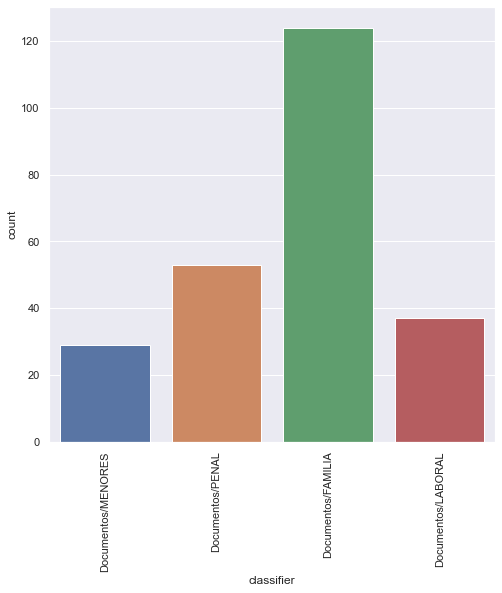

In [147]:
fig, axes = plt.subplots(1, 1 , figsize=(8, 8))

sns.countplot(x = corpus_df['classifier'] , ax = axes )

axes.set_xticklabels(axes.get_xticklabels(),rotation=90)
plt.show()

Se puede observar que el data set esta muy desbalanceado . El desbalanceado para ciertos tipos 
de modelos y arquitecturas de redes neuronales es un problema. Se debe analizar si es posible obtener
más documentos de manera tal de poder tener un data set más balanceado

In [148]:
agregated_corups_df.head()

,text,classifier
0,datos de la causa sede ciudad de córdoba. de...,Documentos/MENORES
1,sala penal - tribunal superior protocolo de s...,Documentos/PENAL
2,auto número sesenta y seis córdoba cinco de...,Documentos/FAMILIA
3,sala laboral - tribunal superior protocolo de...,Documentos/LABORAL


## Nomalización de Texto

In [149]:
#Cargamos el lenguaje español en spacy
spacy_nlp = spacy.load("es_core_news_md") 
spacy_nlp.max_length = 5000000

Doc.set_extension('document_id', default=False, force=True)
Doc.set_extension('classifier', default=False, force=True)


In [150]:
#Vemos las STOP_WORDS que viene definidas por defecto
#spacy.lang.es.stop_words.STOP_WORDS

In [151]:
# Stop_words que no estan contempladas en Spacy y consideramos necesario sacarlas

customs_stop_words = ['y' , 'a', 'e' , 'o' , 'u']


for custom_stop_word in customs_stop_words:
    spacy_nlp.vocab[custom_stop_word].is_stop = True
    spacy.lang.es.stop_words.STOP_WORDS.add(custom_stop_word)

#spacy.lang.es.stop_words.STOP_WORDS

Clases para filtrar y transformar datos en Spacy

In [314]:
class SpacyTextNormalizer:
    def __init__(self):
        
        self.filters = []
        self.transformers = []
        self.documents = []
        
    def addFilter(self, filter):
        self.filters.append(filter)
        
    def addTransformer(self, transformer):
        self.transformers.append(transformer)
        
    
    def fit(self , spacy_tuples):
        self.documents = []
        for doc,context in spacy_tuples:
            
            doc._.document_id = context["document_id"]
            doc._.classifier = context["classifier"]
            self.documents.append(doc)
        
        
    def normalize(self, filters = [], transformers = []):
        documents = []
        for doc in self.documents:
            words = []
            
            for word in doc:
                remove_token = False

                for filter in filters:
                    remove_token = filter.execute(word)
                    if remove_token: 
                        break
        
                if not remove_token:
                    
                    transformed_res = []
                    transformed_res.append(word)
                    
                    for transformer in transformers:
                        transformed_res.append(transformer.transform(word))
                        
                    words.append(transformed_res)       
        
            documents.append(( doc ,words))
        
        return documents

In [315]:
class MapMultipleCharsProcessor:

    def process(self, text , replace_chars):
        
        for ch in replace_chars:
            text = text.replace(ch[0],ch[1])

        
        return text

In [316]:
class Timer:
    
    def start(self):
        self.start_ = datetime.datetime.now()
        
    def stop(self):
       
        self.stop_ = datetime.datetime.now()
        print (f"Tiempo de procesamiento: {self.stop_ - self.start_}")

    def print_stats(self):
        print (f"Tiempo de procesamiento: {self.stop_ - self.start_}")

timer = Timer()

In [317]:
chars_replace = [('á' , 'a') , ('é' , 'e') , ('í', 'i') , ('ó' , 'o') , ('ú' , 'u'), ('-' , '')]
mapMultipleCharsProcessor = MapMultipleCharsProcessor()
mapMultipleCharsProcessor.process("Holá ú esté" , chars_replace)

'Hola u este'

In [381]:
class RemoveStopWordsFilter:
    def execute(self, word):
        return word.is_stop 

class RemovePuntctuationFilter:
    def execute(self, word):
        return word.is_punct
    
class RemoveSpaceFilter:
    def execute(self, word):
        return word.is_space

class RemoveNumber:
    def execute(self,word):
        return (word.like_num or word.is_digit or word.lemma_.isnumeric())
    
class RemoveDate:
    def execute(self,word):
        return re.search("^([1-9]|0[1-9]|1[0-9]|2[0-9]|3[0-1])(\.|-|/)([1-9]|0[1-9]|1[0-2])(\.|-|/)([0-9][0-9]|19[0-9][0-9]|20[0-9][0-9])$|^([0-9][0-9]|19[0-9][0-9]|20[0-9][0-9])(\.|-|/)([1-9]|0[1-9]|1[0-2])(\.|-|/)([1-9]|0[1-9]|1[0-9]|2[0-9]|3[0-1])$", word.lemma_)
    
class ToLowerCaseTransformer:
    def transform(self, word):
        return word.lower_
    
class ToLemaTransformer:
    def transform(self, word):
        return mapMultipleCharsProcessor.process(word.lemma_ , chars_replace)
    

In [418]:
fecha = "29/1/1900"
if re.search("^([1-9]|0[1-9]|1[0-9]|2[0-9]|3[0-1])(\.|-|/)([1-9]|0[1-9]|1[0-2])(\.|-|/)([0-9][0-9]|19[0-9][0-9]|20[0-9][0-9])$|^([0-9][0-9]|19[0-9][0-9]|20[0-9][0-9])(\.|-|/)([1-9]|0[1-9]|1[0-2])(\.|-|/)([1-9]|0[1-9]|1[0-9]|2[0-9]|3[0-1])$",fecha):
    print ("Si")

Si


Filtros y transformes que vamos a utilizar para normalizar los datos

In [383]:
#Filtros y transformers

removeSpaceFilter = RemoveSpaceFilter()
removeStopWordsFilter = RemoveStopWordsFilter()
removePuntctuationFilter = RemovePuntctuationFilter()
removeNumber = RemoveNumber()
removeDate = RemoveDate()

toLowerCaseTransformer = ToLowerCaseTransformer()
toLemaTransformer = ToLemaTransformer()

spacyTextNormalizer = SpacyTextNormalizer()

In [419]:
# Prueba de filtros y transformers ()

texto = [
    ("Esta es una pregunta? 10/10/2020) Tenes que llamar a 1000 -Christian y a Gonzalo", {"document_id": "1" , "classifier" : "PENAL"} )
    ]

doc_tuples = spacy_nlp.pipe(texto , as_tuples=True , n_process=-1  )

spacyTextNormalizerTest = SpacyTextNormalizer()


spacyTextNormalizerTest.fit(doc_tuples)
result_test = spacyTextNormalizerTest.normalize(transformers=[toLemaTransformer] , filters=[removeStopWordsFilter , removePuntctuationFilter , removeNumber , removeDate ])

In [420]:
result_test

[(Esta es una pregunta? 10/10/2020) Tenes que llamar a 1000 -Christian y a Gonzalo,
  [[pregunta, 'pregunta'],
   [Tenes, 'Tenes'],
   [llamar, 'llamar'],
   [-Christian, 'christian'],
   [Gonzalo, 'Gonzalo']])]

In [391]:
# Extremadamente lento este enfoque para el caso de procesar el copus por fuero. El length del string del texto del corpus es 'grande' y 
# hace que sea lento el procesamiento
# Código deprecado

if False:
    texto = [(agregated_corups_df.iloc[2,].text , {"text_id": "1"})]

    doc_tuples = spacy_nlp.pipe(texto , as_tuples=True ,batch_size=50, n_process=4 , disable=["tok2vec", "tagger",  "attribute_ruler"] )

    result = spacyTextNormalizer.normalize(doc_tuples)

In [392]:
#Armamos el array de tuplas a partir del data frame corpus_df. Usamos este data frame y no el agregated_corups_df puesto
# que el array de texto por tupla es muy grande y Spacy requiere más memoria ademas de se notablemente lento

#load_from_pickle = False
if not load_from_pickle:

    texto = corpus_df.apply( lambda x : (x['text'] , {"document_id": x['id'] ,"classifier" : x["classifier"] }) , axis=1)
    timer.start()
    doc_tuples = spacy_nlp.pipe(texto , as_tuples=True ,batch_size=50, n_process=4  )

    spacyTextNormalizer.fit(doc_tuples)
    timer.stop()

Tiempo de procesamiento: 0:02:13.865982


In [393]:
# Poniendo a True serealizamos la instancia spacyTextNormalizer. Esto no permite reconstruir el objeto por medio del
# archivo serealizado. Levantar el archivo y recrear el objeto es mucho más rápido de recostruir el objeto usando nlp.pipe y fit
if False:
    timer.start()
    filehandler = open("normilizer.pkl", 'wb') 
    pickle.dump(spacyTextNormalizer, filehandler)
    timer.stop()

Tiempo de procesamiento: 0:00:09.122894


In [394]:
#Recreamos el objeto spacyTextNormalizer desde un archivo, ver la explicación del punto anterior

#load_from_pickle = True

if load_from_pickle:
    
    timer.start()
    filehandler = open("normilizer.pkl", 'rb') 
    spacyTextNormalizer = pickle.load(filehandler)
    timer.stop()
    

In [395]:
timer.start()

filters = [removeSpaceFilter,removeStopWordsFilter ,removePuntctuationFilter ,removeNumber , removeDate]

transformers = [toLemaTransformer]

result = spacyTextNormalizer.normalize(filters=filters, transformers=transformers)

timer.stop()

Tiempo de procesamiento: 0:00:04.357812


In [396]:
result[242][0]._.document_id

'bc6b79c0bfd70165dd19eee02a897443'

In [397]:
def get_words_list(document):
    words = [ word[1] for word in document]
    return words
    

def get_word_count_df(document ,ngram_cardinality = [1] ):

    result = []
    
    for ngram in ngram_cardinality:
        words = get_words_list(document)
        
        if ngram != 1:
            words = ngrams(words, ngram)
           
        counter = Counter (words)
        
        most_common_words = []
        for word in counter.most_common():
            most_common_words.append(word + (ngram,))
        
        result = result + most_common_words
    
    return pd.DataFrame(data = result  , columns= [ "word" , "count" , "ngram"])


def create_corpus_count_df(documents , ngram_cardinality = [1]):

    column_names = ["word", "count", "id" , "classifier"]

    merged_df = pd.DataFrame(columns = column_names)

    for document in documents:

        doc_df = get_word_count_df(document[1] , ngram_cardinality)
        doc_df['id'] = document[0]._.document_id
        doc_df['classifier'] = document[0]._.classifier
        merged_df = merged_df.append(doc_df, ignore_index = True)


    return merged_df

def create_cleaned_corpus__df(documents):

    column_names = ["text" , "id" , "classifier"]

    merged_df = pd.DataFrame(columns = column_names)

    for document in documents:

        doc_df = pd.DataFrame(data = [" ".join(get_words_list(document[1]))]  , columns= [ "text" ])
        #doc_df = pd.DataFrame(data = [" ".join(["s","s"])]  , columns= [ "text" ])
        
        doc_df['id'] = document[0]._.document_id
        doc_df['classifier'] = document[0]._.classifier
        merged_df = merged_df.append(doc_df, ignore_index = True)


    return merged_df

In [398]:
#Este corpus tiene el texto de los documentos normalizado
timer.start()
df_cleaned_corpus = create_cleaned_corpus__df(result)
timer.stop()
df_cleaned_corpus

Tiempo de procesamiento: 0:00:00.492449


,text,id,classifier
0,dato causa sede ciudad cordoba dependencia juz...,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES
1,univoco fecha materia niñez revista familia ni...,1f9cdcb2c2596656b540c1271fc2d843,Documentos/MENORES
2,juzgado niñez juventud violencia familiar 8ª n...,17dcae14592fc6e87680ccb4251d9395,Documentos/MENORES
3,auto caratulado a. a. denuncia violencia gener...,4b3ae58648b6267ebb332feec8002588,Documentos/MENORES
4,juzg niñez adolescencia violencia familiar 4ta...,1316026beaa1d7e6530bdfe7e54f7b5c,Documentos/MENORES
...,...,...,...
238,sala laboral tribunal superior protocolo sente...,5dec7fdd3bdeaafc1ec640e1582f5b08,Documentos/LABORAL
239,sala laboral tribunal superior protocolo sente...,5c1d6beee8e1f99f2959b430eba53fb1,Documentos/LABORAL
240,sala laboral tribunal superior protocolo sente...,b6682a594458229ec8b26e67ceab4cc2,Documentos/LABORAL
241,sala laboral tribunal superior protocolo sente...,a27c00c40e8fc4b357ec24780954f4b1,Documentos/LABORAL


In [399]:
save_cleaned_corpus = True
if save_cleaned_corpus:
    timer.start()
    df_cleaned_corpus.to_csv("cleaned_corpus.csv")
    timer.stop()

Tiempo de procesamiento: 0:00:00.089998


In [228]:
# Se crea DF con conteo de palabras
timer.start()
df_corpus = create_corpus_count_df(result , ngram_cardinality=[1])
timer.stop()
df_corpus

Tiempo de procesamiento: 0:00:04.771194


,word,count,id,classifier,ngram
0,m.,29,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,1.0
1,ley,24,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,1.0
2,violencia,23,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,1.0
3,medida,22,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,1.0
4,familiar,20,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,1.0
...,...,...,...,...,...
205966,mario,1,bc6b79c0bfd70165dd19eee02a897443,Documentos/LABORAL,1.0
205967,martin,1,bc6b79c0bfd70165dd19eee02a897443,Documentos/LABORAL,1.0
205968,lascano,1,bc6b79c0bfd70165dd19eee02a897443,Documentos/LABORAL,1.0
205969,eduardo,1,bc6b79c0bfd70165dd19eee02a897443,Documentos/LABORAL,1.0


In [229]:
# Se crea DF con conteo de ngramas
timer.start()
df_corpus_nagram = create_corpus_count_df(result , ngram_cardinality=[2,3])
timer.stop()
df_corpus_nagram

Tiempo de procesamiento: 0:00:20.339632


,word,count,id,classifier,ngram
0,"(violencia, familiar)",14,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,2.0
1,"(m., c.)",13,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,2.0
2,"(sr, m.)",13,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,2.0
3,"(c., m.)",11,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,2.0
4,"(sra, s.)",11,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES,2.0
...,...,...,...,...,...
910980,"(fecha, lascano, eduardo)",1,bc6b79c0bfd70165dd19eee02a897443,Documentos/LABORAL,3.0
910981,"(lascano, eduardo, javier)",1,bc6b79c0bfd70165dd19eee02a897443,Documentos/LABORAL,3.0
910982,"(eduardo, javier, fecha)",1,bc6b79c0bfd70165dd19eee02a897443,Documentos/LABORAL,3.0
910983,"(javier, fecha, expediente)",1,bc6b79c0bfd70165dd19eee02a897443,Documentos/LABORAL,3.0


In [230]:
def get_grouped_df_by_classifier(df_corpus , classifier = "ALL"):
    
    if classifier == "ALL":
        df_grouped = df_corpus.groupby(['word'] , as_index=False).agg({'count': ['sum']})
    else:
        df_grouped = df_corpus[df_corpus['classifier'] == classifier].groupby(['word'] , as_index=False).agg({'count': ['sum']})

    df_grouped = df_grouped.sort_values(by=[('count' , 'sum')],ascending = False)[:50]
    df_grouped.droplevel(axis=1, level=0).reset_index()
    df_grouped.columns  =[ "word", "count"]
    return df_grouped

In [231]:
timer.start()

df_menores = get_grouped_df_by_classifier(df_corpus , 'Documentos/MENORES')
df_laboral = get_grouped_df_by_classifier(df_corpus , 'Documentos/LABORAL')
df_penal = get_grouped_df_by_classifier(df_corpus , 'Documentos/PENAL')
df_familia = get_grouped_df_by_classifier(df_corpus , 'Documentos/FAMILIA')
df_all = get_grouped_df_by_classifier(df_corpus )
timer.stop()

Tiempo de procesamiento: 0:00:08.341167


In [232]:
df_all[:4]

,word,count
4744,art,4332
11703,fs,4284
14827,ley,3123
5106,auto,2644


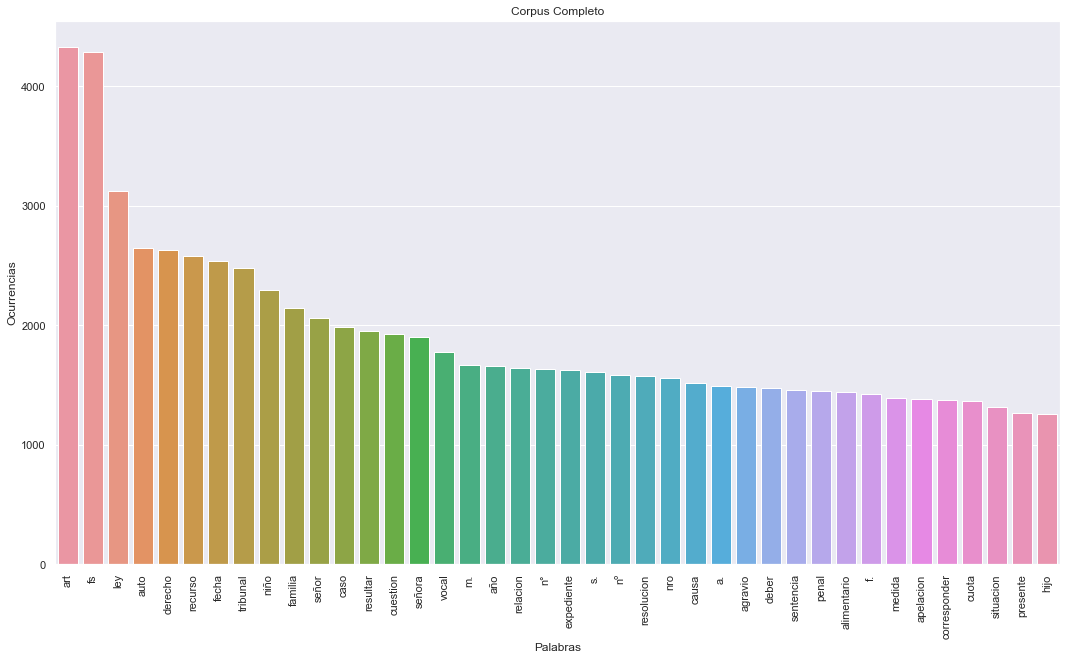

In [233]:
limit_to_plot=40

fig, axes = plt.subplots(1, 1 , figsize=(18, 10))

graph_cba.plot_word_frequency (axes = axes, x = "word" , y = "count", df = df_all ,title ="Corpus Completo" , limit_to_plot = limit_to_plot  )

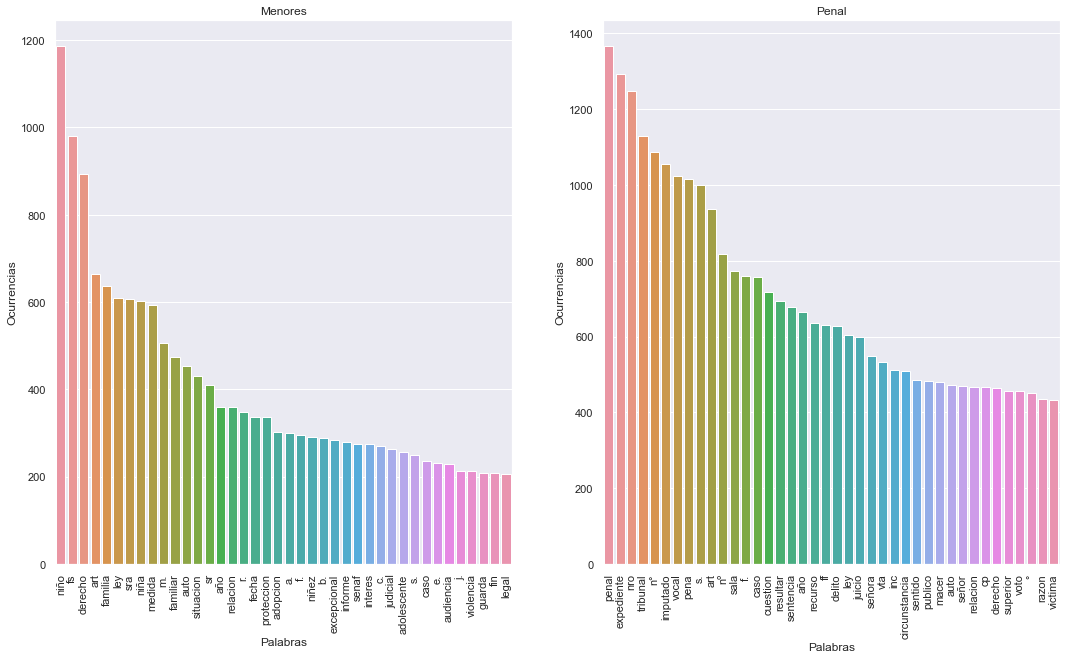

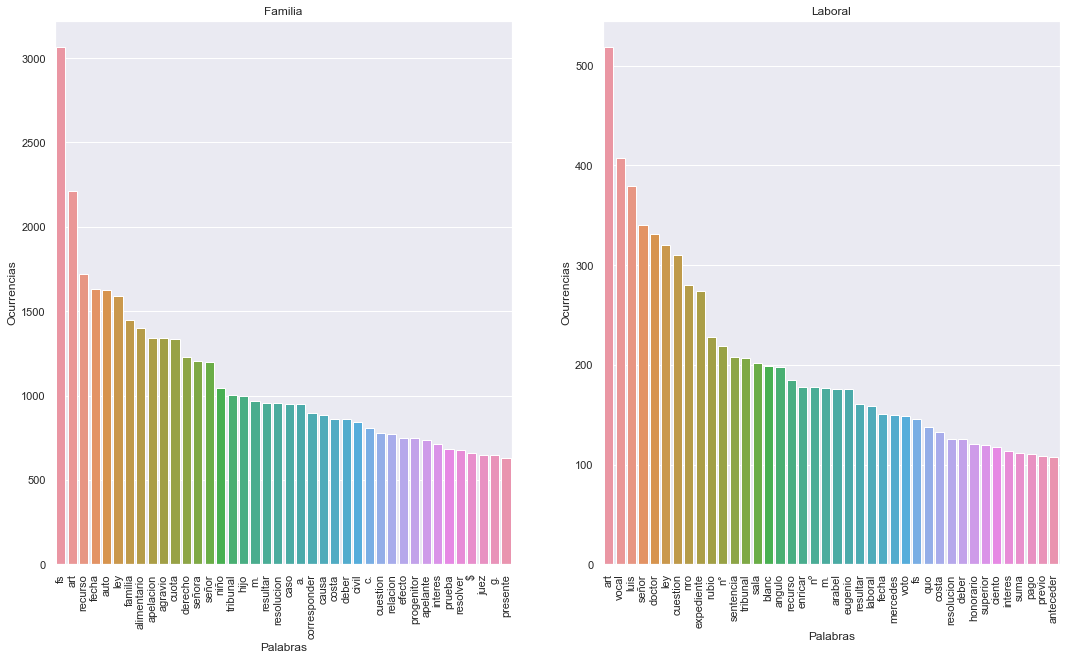

In [234]:
fig, axes = plt.subplots(1, 2 , figsize=(18, 10))

graph_cba.plot_word_frequency (axes = axes[0], x = "word" , y = "count", df = df_menores ,title ="Menores" , limit_to_plot = limit_to_plot )
graph_cba.plot_word_frequency (axes = axes[1], x = "word" , y = "count", df = df_penal ,title ="Penal" , limit_to_plot = limit_to_plot )


fig, axes = plt.subplots(1, 2 , figsize=(18, 10))

graph_cba.plot_word_frequency (axes = axes[0], x = "word" , y = "count", df = df_familia ,title ="Familia" , limit_to_plot = limit_to_plot )
graph_cba.plot_word_frequency (axes = axes[1], x = "word" , y = "count", df = df_laboral ,title ="Laboral" , limit_to_plot = limit_to_plot )

In [235]:
timer.start()

df_menores_ngram = get_grouped_df_by_classifier(df_corpus_nagram[df_corpus_nagram["ngram"] == 2] , 'Documentos/MENORES')
df_laboral_ngram = get_grouped_df_by_classifier(df_corpus_nagram[df_corpus_nagram["ngram"] == 2] , 'Documentos/LABORAL')
df_penal_ngram = get_grouped_df_by_classifier(df_corpus_nagram[df_corpus_nagram["ngram"] == 2] , 'Documentos/PENAL')
df_familia_ngram = get_grouped_df_by_classifier(df_corpus_nagram[df_corpus_nagram["ngram"] == 2] , 'Documentos/FAMILIA')

timer.stop()

Tiempo de procesamiento: 0:00:39.802332


In [236]:
df_menores[:10]

,word,count
5041,niño,1186
3446,fs,980
2263,derecho,894
954,art,664
3262,familia,636
4515,ley,610
6930,sra,608
5038,niña,603
4785,medida,593
4623,m.,507


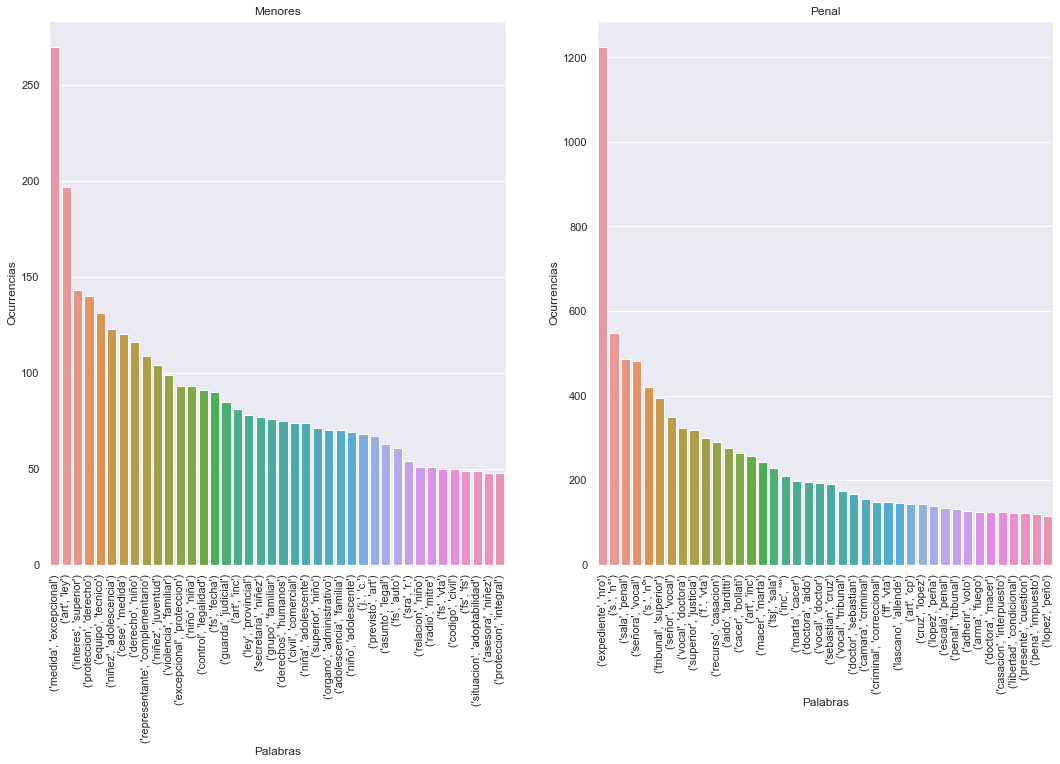

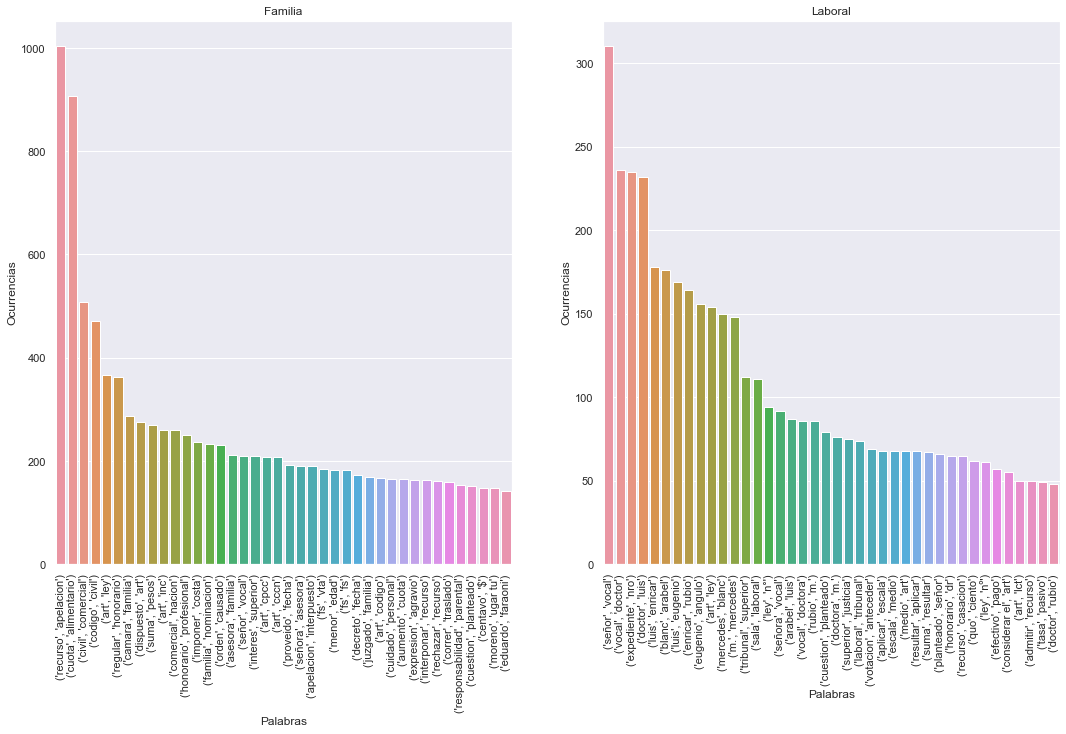

In [237]:
fig, axes = plt.subplots(1, 2 , figsize=(18, 10))

graph_cba.plot_word_frequency (axes = axes[0], x = "word" , y = "count", df = df_menores_ngram ,title ="Menores" , limit_to_plot = limit_to_plot )
graph_cba.plot_word_frequency (axes = axes[1], x = "word" , y = "count", df = df_penal_ngram ,title ="Penal" , limit_to_plot = limit_to_plot )


fig, axes = plt.subplots(1, 2 , figsize=(18, 10))

graph_cba.plot_word_frequency (axes = axes[0], x = "word" , y = "count", df = df_familia_ngram ,title ="Familia" , limit_to_plot = limit_to_plot )
graph_cba.plot_word_frequency (axes = axes[1], x = "word" , y = "count", df = df_laboral_ngram ,title ="Laboral" , limit_to_plot = limit_to_plot )

In [238]:
timer.start()

df_menores_ngram = get_grouped_df_by_classifier(df_corpus_nagram[df_corpus_nagram["ngram"] == 3] , 'Documentos/MENORES')
df_laboral_ngram = get_grouped_df_by_classifier(df_corpus_nagram[df_corpus_nagram["ngram"] == 3] , 'Documentos/LABORAL')
df_penal_ngram = get_grouped_df_by_classifier(df_corpus_nagram[df_corpus_nagram["ngram"] == 3] , 'Documentos/PENAL')
df_familia_ngram = get_grouped_df_by_classifier(df_corpus_nagram[df_corpus_nagram["ngram"] == 3] , 'Documentos/FAMILIA')

timer.stop()

Tiempo de procesamiento: 0:00:54.510010


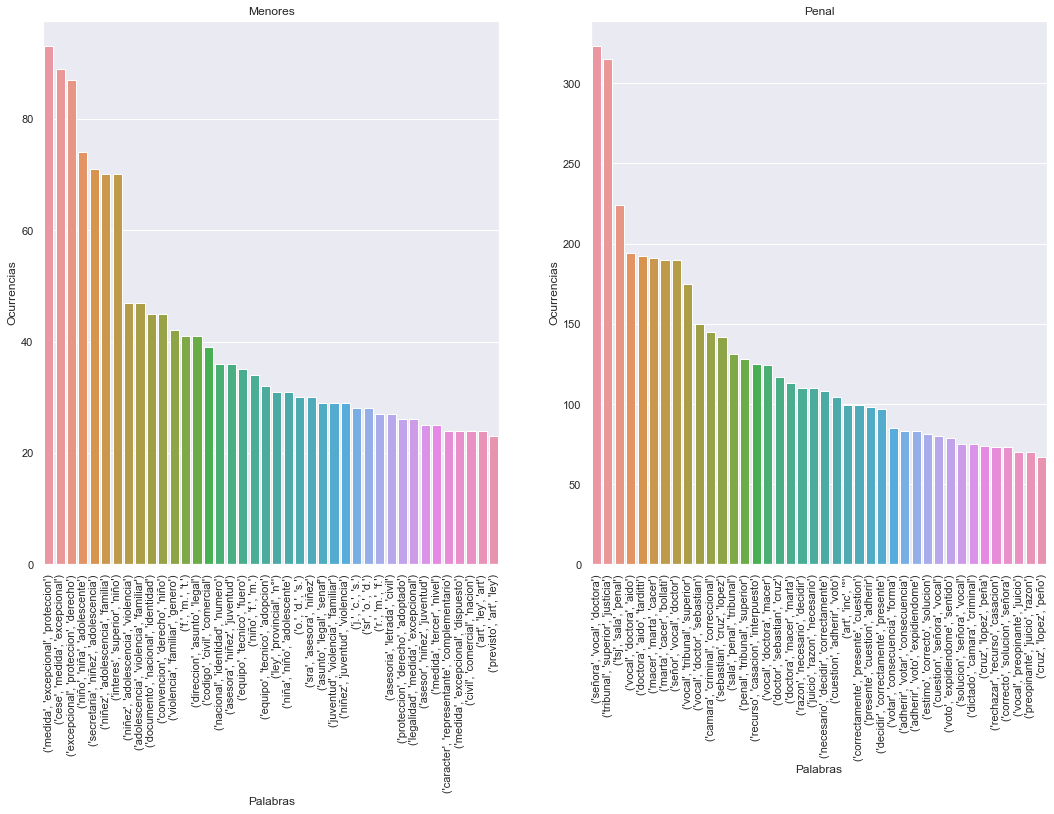

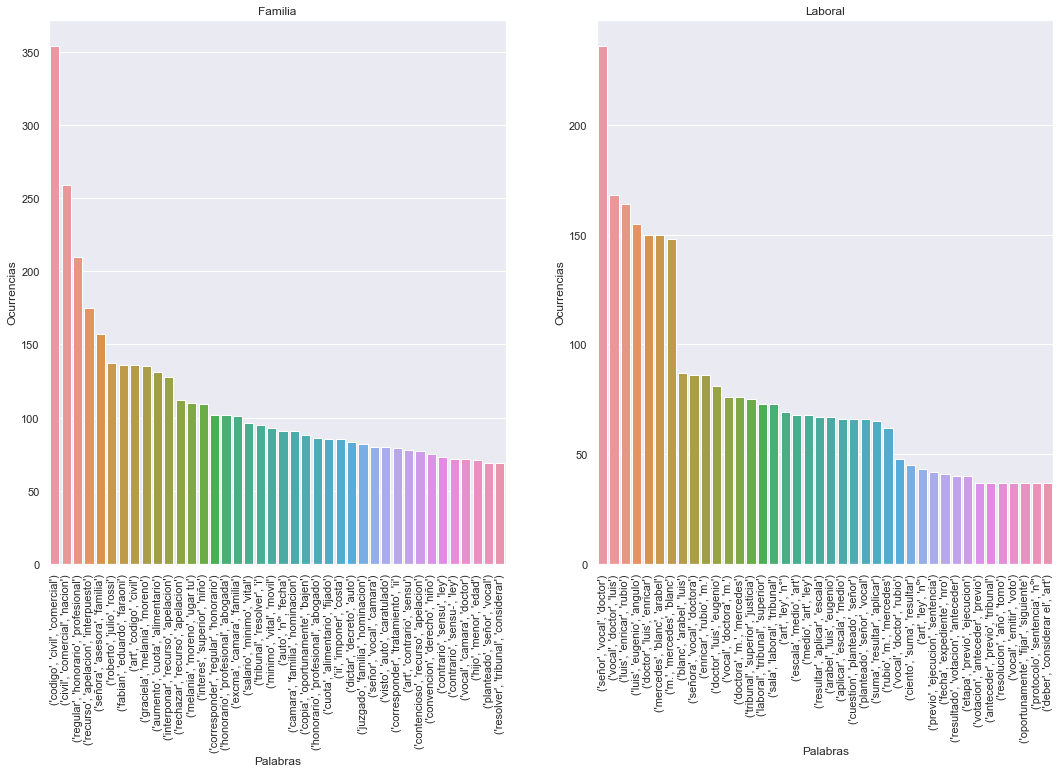

In [239]:
fig, axes = plt.subplots(1, 2 ,figsize=(18, 10))

graph_cba.plot_word_frequency (axes = axes[0], x = "word" , y = "count", df = df_menores_ngram ,title ="Menores" , limit_to_plot = limit_to_plot )
graph_cba.plot_word_frequency (axes = axes[1], x = "word" , y = "count", df = df_penal_ngram ,title ="Penal" , limit_to_plot = limit_to_plot )


fig, axes = plt.subplots(1, 2 , figsize=(18, 10))

graph_cba.plot_word_frequency (axes = axes[0], x = "word" , y = "count", df = df_familia_ngram ,title ="Familia" , limit_to_plot = limit_to_plot )
graph_cba.plot_word_frequency (axes = axes[1], x = "word" , y = "count", df = df_laboral_ngram ,title ="Laboral" , limit_to_plot = limit_to_plot )

Al utilizar bigramas y trigramas se puede observar que ciertos bigramas / trigamas son característicos para documentos de ciertos fueros. Por ejemplo  

- Familia:  “ cámara familia”, “recurso apleacion”, menores
- Menores: “medida excepcional” , “ley 9944”

Quizás al momento de entrenar modelos y/o redes neuronales, seria adecuado utilizar las palabras individuales y bigramas / trigramas

Al utilizar CountVectorizer, se nota:

- la existencia de una gran cantidad de números, muchos de ellos referidos a montos o sumas de dinero a pagar. Esto entendemos no suma información a los modelos y deben ser eliminados. El desarfío esta en conservar los números que representan leyes y articulos. El resto debería ser eliminado. Al realizar el CountVectorizer, se obtiene una matriz de 243x25929. Sacando todos los números, la matriz queda de 243x22320

- la existencia de fechas. Estas fechas entendemos que tampoco sumana información a los modelos y deben ser eliminados. (implementar eliminación)

- la existencia de muchas palabras que tienen como prefixo y/o sufijo, el signo "-"

## Anexo

In [400]:
from sklearn.feature_extraction.text import CountVectorizer

In [401]:
df_cleaned_corpus

,text,id,classifier
0,dato causa sede ciudad cordoba dependencia juz...,4de122c24ab1606c9d67f4ff9e656143,Documentos/MENORES
1,univoco fecha materia niñez revista familia ni...,1f9cdcb2c2596656b540c1271fc2d843,Documentos/MENORES
2,juzgado niñez juventud violencia familiar 8ª n...,17dcae14592fc6e87680ccb4251d9395,Documentos/MENORES
3,auto caratulado a. a. denuncia violencia gener...,4b3ae58648b6267ebb332feec8002588,Documentos/MENORES
4,juzg niñez adolescencia violencia familiar 4ta...,1316026beaa1d7e6530bdfe7e54f7b5c,Documentos/MENORES
...,...,...,...
238,sala laboral tribunal superior protocolo sente...,5dec7fdd3bdeaafc1ec640e1582f5b08,Documentos/LABORAL
239,sala laboral tribunal superior protocolo sente...,5c1d6beee8e1f99f2959b430eba53fb1,Documentos/LABORAL
240,sala laboral tribunal superior protocolo sente...,b6682a594458229ec8b26e67ceab4cc2,Documentos/LABORAL
241,sala laboral tribunal superior protocolo sente...,a27c00c40e8fc4b357ec24780954f4b1,Documentos/LABORAL


In [412]:
count_vectorizer = CountVectorizer(tokenizer=str.split , token_pattern = ' ' , max_features = 100000 )
vector_matrix = count_vectorizer.fit_transform(df_cleaned_corpus['text'])
vector_matrix

<243x19503 sparse matrix of type '<class 'numpy.int64'>'
	with 199996 stored elements in Compressed Sparse Row format>

In [413]:
tokens = count_vectorizer.get_feature_names()
tokens

['\x01',
 '\x07',
 '\x07\x01',
 '\x0710/02/2020',
 '\x0721081',
 '\x0724/08/2020',
 '\x07a',
 '\x07camar',
 '\x07caratula',
 '\x07competencia',
 '\x07descripcion',
 '\x07fecha',
 '\x07juzgado',
 '\x07materia',
 '\x07niñez',
 '\x07resolucion',
 '\x07titulo',
 '\x07tribunal',
 '\x07violencia',
 '\x07y',
 '\x07“n',
 '\x07“r',
 '"(sic',
 '"mattei',
 '"q',
 '$',
 '$3.118',
 ')hacer',
 ')¿que',
 ')¿se',
 '*1',
 '+',
 '.',
 '.a',
 '.abeledo',
 '.adoptar',
 '.asimismo',
 '.car',
 '.con',
 '.confor',
 '.e',
 '.g',
 '.i',
 '.j',
 '.la',
 '.los',
 '.n',
 '.ordir',
 '.podria',
 '.que',
 '.se',
 '.toda',
 '.v',
 '.vi',
 '.y',
 '//ap.ohchr.org',
 '//dle.rae.es/?w',
 '//nulan.mdp.edu.ar/2243/',
 '//wadmin.uca.edu.ar',
 '//www.abeledoperrotonline2.com',
 '//www.acaderc.org.ar',
 '//www.bcra.gov.ar/',
 '//www.cadena3.com',
 '//www.codajic.org',
 '//www.corteidh.or.cr',
 '//www.cpcecba.org.ar',
 '//www.diariojudicial.com',
 '//www.dolarsi.com',
 '//www.eldial.com/',
 '//www.epec.com.ar',
 '//www.faceboo

In [410]:
def create_dataframe(matrix, tokens):

    doc_names = [f'doc_{i+1}' for i, _ in enumerate(matrix)]
    df = pd.DataFrame(data=matrix, index=doc_names, columns=tokens)
    return(df)

create_dataframe(vector_matrix.toarray(),tokens)

,,,,10/02/2020,21081,24/08/2020,a,camar,caratula,competencia,...,©,°,´,º,–f.v,–h,“crece,“m,■,♦
doc_1,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,0,0,0,0,0,0
doc_2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
doc_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc_4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc_5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
doc_239,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc_240,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc_241,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
doc_242,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Prueba Varias

In [101]:
#Guardamos información de contexto del documento
spacy.tokens.doc.Doc.set_extension('text_id' , default =False , force = True)
doc_tuples = spacy_nlp.pipe([("Hola esto es una prueba que te parece" , {"text_id" : "text_id1_1"})] , as_tuples=True , n_process=-1)
docs = []

for doc, context in doc_tuples:
    doc._.text_id = context["text_id"]
    docs.append(doc)

In [ ]:
for doc in docs:
    for token in doc:
        print(f"ddd.{token.text} {token.is_sent_start}  {token.lemma_} {token.norm_} {token.pos_}{doc._.text_id} ")